# Import Packages/Library yang akan digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import random
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image

In [3]:
# install tensorflowjs
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

In [4]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

2025-05-21 08:48:13.738235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747817293.975535      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747817294.039928      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# menonaktifkan warning yang mungkin muncul
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# Data Preparation

## Data Loading

In [6]:
path = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES"

In [7]:
# Membuat List Data
data = []
for class_name in os.listdir(path):
    class_dir = os.path.join(path, class_name)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, img_file)
            data.append([file_path, class_name])

# Membuat data frame
df = pd.DataFrame(data, columns=['img', 'label'])

print(df.head())

                                                 img           label
0  /kaggle/input/skin-diseases-image-dataset/IMG_...  1. Eczema 1677
1  /kaggle/input/skin-diseases-image-dataset/IMG_...  1. Eczema 1677
2  /kaggle/input/skin-diseases-image-dataset/IMG_...  1. Eczema 1677
3  /kaggle/input/skin-diseases-image-dataset/IMG_...  1. Eczema 1677
4  /kaggle/input/skin-diseases-image-dataset/IMG_...  1. Eczema 1677


In [8]:
#ganti nama label
label_mapping = {
    '1. Eczema 1677': 'Eczema',
    '2. Melanoma 15.75k': 'Melanoma',
    '3. Atopic Dermatitis - 1.25k': 'Atopic Dermatitis',
    '4. Basal Cell Carcinoma (BCC) 3323': 'Basal Cell Carcinoma (BCC)',
    '5. Melanocytic Nevi (NV) - 7970': 'Melanocytic Nevi (NV)',
    '6. Benign Keratosis-like Lesions (BKL) 2624': 'Benign Keratosis-like Lesions (BKL)',
    '7. Psoriasis pictures Lichen Planus and related diseases - 2k': 'Psoriasis pictures Lichen Planus and related diseases',
    '8. Seborrheic Keratoses and other Benign Tumors - 1.8k': 'Seborrheic Keratoses and other Benign Tumors',
    '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k': 'Tinea Ringworm Candidiasis and other Fungal Infections',
    '10. Warts Molluscum and other Viral Infections - 2103': 'Warts Molluscum and other Viral Infections'
}

df['label'] = df['label'].replace(label_mapping)

In [9]:
# Melihat banyaknya data pada setiap label
df.groupby('label', as_index=False).count()

,label,img
0,Atopic Dermatitis,1257
1,Basal Cell Carcinoma (BCC),3323
2,Benign Keratosis-like Lesions (BKL),2079
3,Eczema,1677
4,Melanocytic Nevi (NV),7970
5,Melanoma,3140
6,Psoriasis pictures Lichen Planus and related d...,2055
7,Seborrheic Keratoses and other Benign Tumors,1847
8,Tinea Ringworm Candidiasis and other Fungal In...,1702
9,Warts Molluscum and other Viral Infections,2103


/tmp/ipykernel_19/1583116689.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected_images = df.groupby('label', as_index=False).apply(lambda x: x.sample(n=5, random_state=1)).reset_index(drop=True)


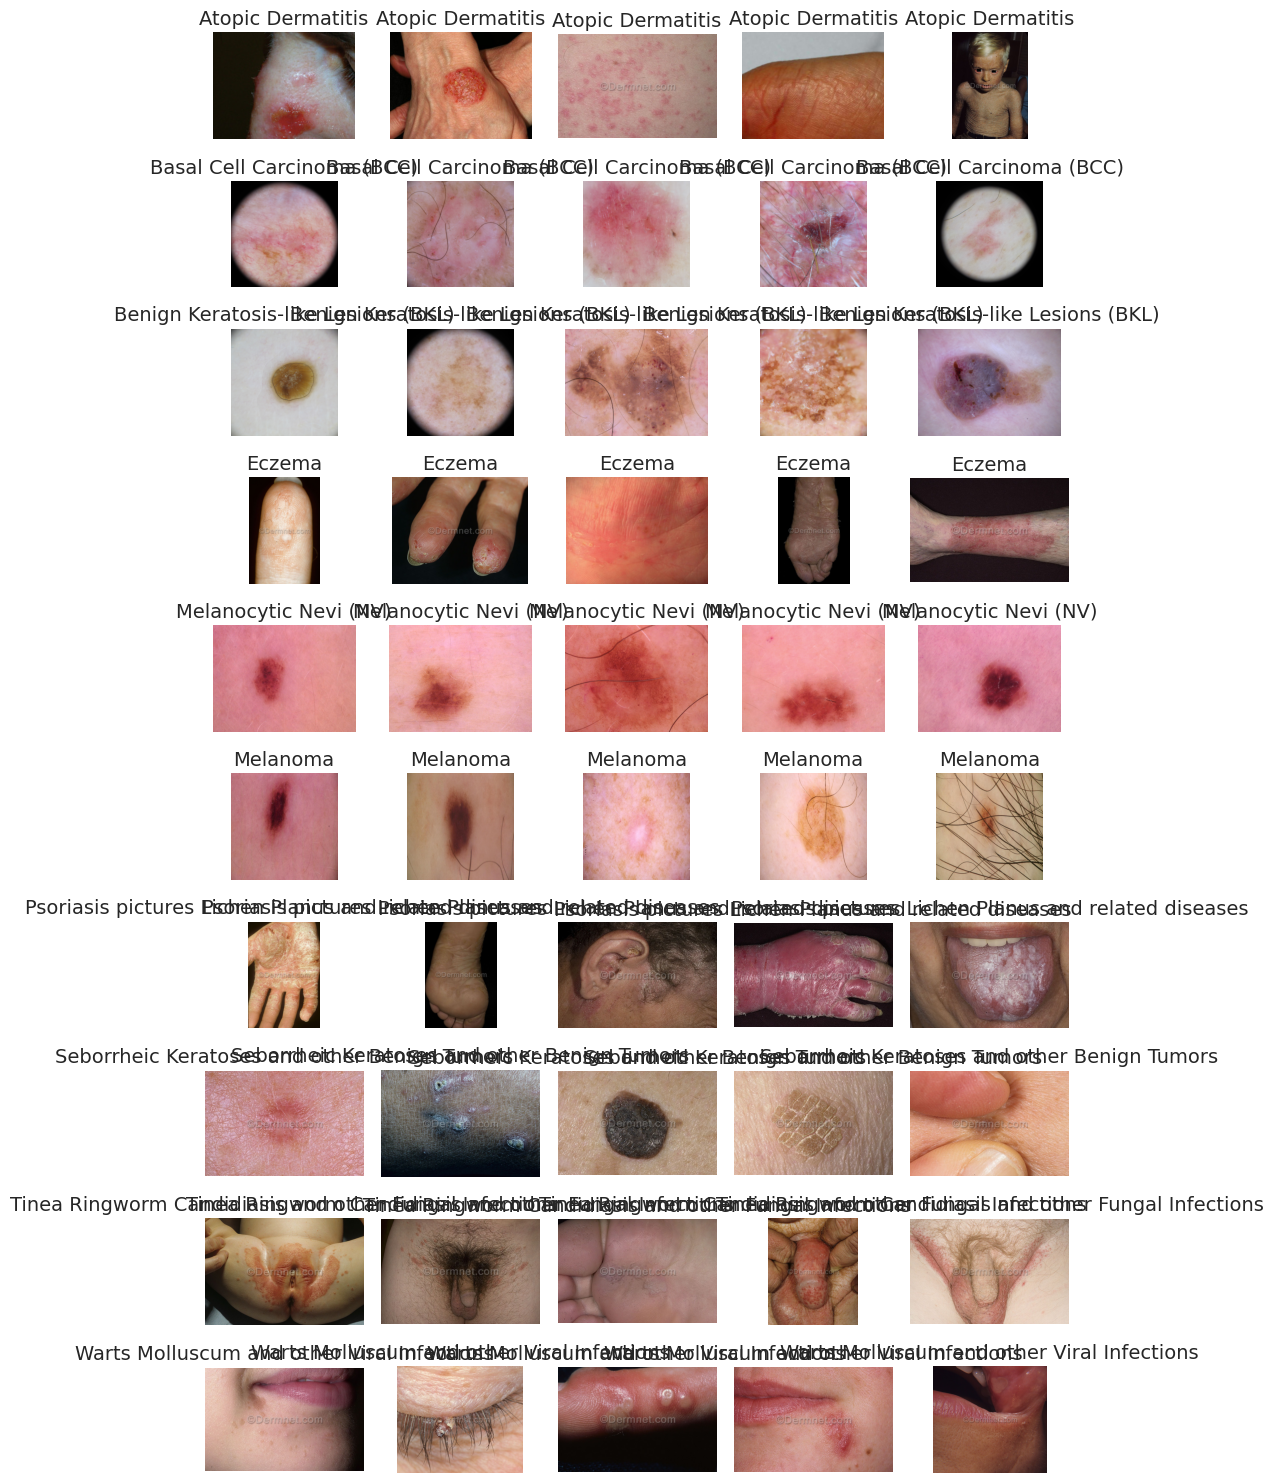

In [10]:
labels = df.label.unique()

# Data visualisasi pakai Seaborn
selected_images = df.groupby('label', as_index=False).apply(lambda x: x.sample(n=5, random_state=1)).reset_index(drop=True)

sns.set(style='whitegrid')
fig, axes = plt.subplots(len(labels), 5, figsize=(9, len(labels)*1.5))

axes = axes.flatten()

for ax, (img_path, label) in zip(axes, zip(selected_images['img'], selected_images['label'])):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label, fontsize=14)

plt.tight_layout()
plt.show()

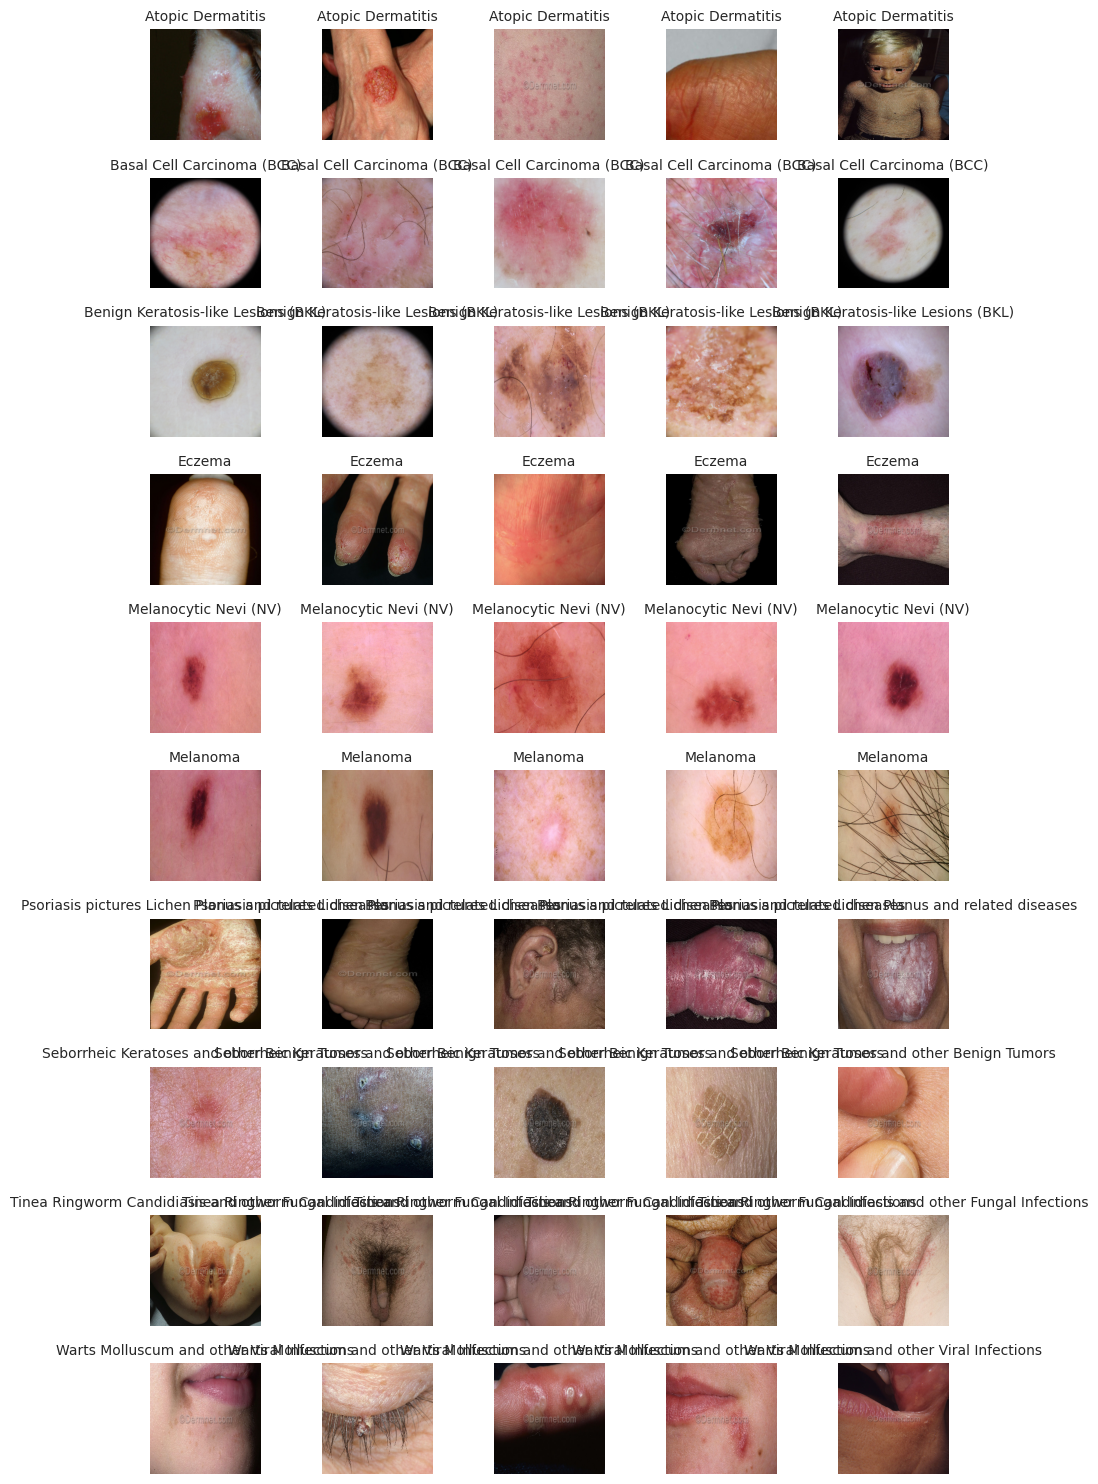

In [11]:
# Ukuran tetap untuk semua gambar
image_size = (224, 224)

sns.set(style='whitegrid')
fig, axes = plt.subplots(len(labels), 5, figsize=(9, len(labels)*1.5))
axes = axes.flatten()

for ax, (img_path, label) in zip(axes, zip(selected_images['img'], selected_images['label'])):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)  # Ubah ukuran gambar di sini
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label, fontsize=10)  # Sedikit kecil agar muat

plt.tight_layout()
plt.show()

## Data Splitting

In [12]:
# Acak dulu dataset (meskipun stratify juga mengacak internalnya)
df = df.sample(frac=1, random_state=32).reset_index(drop=True)

# Split 80% train dan 20% temp (val + test)
train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)

# Split 20% temp menjadi 10% val dan 10% test
validation_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

In [13]:
# Jumlah gambar per batch saat training
batch_size = 16

# Shape input untuk model (tinggi, lebar, channel RGB)
input_shape = (224, 224, 3)

# Definisikan augmentasi untuk training
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalisasi piksel
    rotation_range=40,       # Rotasi acak hingga 40 derajat
    width_shift_range=0.2,   # Pergeseran horizontal acak hingga 20% lebar
    height_shift_range=0.2,  # Pergeseran vertikal acak hingga 20% tinggi
    shear_range=0.2,         # Shear transformation hingga 20%
    zoom_range=0.2,          # Zoom acak hingga 20%
    horizontal_flip=True,    # Izinkan flip horizontal acak
    fill_mode='nearest'      # Isi piksel baru dengan piksel terdekat
)

# Membuat generator untuk data training, testing dan validation
train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='img',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

validation_data = datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='img',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

test_data = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='img',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 21722 validated image filenames belonging to 10 classes.
Found 2715 validated image filenames belonging to 10 classes.
Found 2716 validated image filenames belonging to 10 classes.


In [14]:
print("Class Indices:", train_data.class_indices)

Class Indices: {'Atopic Dermatitis': 0, 'Basal Cell Carcinoma (BCC)': 1, 'Benign Keratosis-like Lesions (BKL)': 2, 'Eczema': 3, 'Melanocytic Nevi (NV)': 4, 'Melanoma': 5, 'Psoriasis pictures Lichen Planus and related diseases': 6, 'Seborrheic Keratoses and other Benign Tumors': 7, 'Tinea Ringworm Candidiasis and other Fungal Infections': 8, 'Warts Molluscum and other Viral Infections': 9}


# Modelling CNN

In [15]:
# Membuat model berurutan (Sequential), setiap layer ditambahkan satu per satu
model = Sequential()
model.add(Input(shape=(224, 224, 3)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer: jumlah neuron = jumlah kelas, aktivasi softmax untuk multi-class classification
model.add(Dense(len(labels), activation='softmax'))

# Kompilasi model: optimizer Adam, loss categorical_crossentropy (karena multi-class), metric accuracy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1747817517.753782      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747817517.754464      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [16]:
# CallBack
# Berhenti training jika val_loss tidak membaik 5 epoch berturut-turut.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Turunkan learning rate jika val_loss tidak membaik dalam 2 epoch.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Mulai training model dengan early stopping dan pengaturan learning rate otomatis.
history = model.fit(train_data, epochs=20, validation_data= validation_data, verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747817528.488128      74 service.cc:148] XLA service 0x7fa374012040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747817528.489151      74 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747817528.489174      74 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747817528.931931      74 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1358 ━━━━━━━━━━━━━━━━━━━━ 5:02:29 13s/step - accuracy: 0.2500 - loss: 2.4386

I0000 00:00:1747817533.733178      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 733s 530ms/step - accuracy: 0.3791 - loss: 1.7488 - val_accuracy: 0.4195 - val_loss: 2.1603 - learning_rate: 0.0010
Epoch 2/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 439s 322ms/step - accuracy: 0.4511 - loss: 1.4783 - val_accuracy: 0.2597 - val_loss: 2.0533 - learning_rate: 0.0010
Epoch 3/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 439s 322ms/step - accuracy: 0.4717 - loss: 1.4094 - val_accuracy: 0.3878 - val_loss: 2.0463 - learning_rate: 0.0010
Epoch 4/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 419s 307ms/step - accuracy: 0.4879 - loss: 1.3557 - val_accuracy: 0.3366 - val_loss: 2.4519 - learning_rate: 0.0010
Epoch 5/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 383s 281ms/step - accuracy: 0.5178 - loss: 1.2878 - val_accuracy: 0.2634 - val_loss: 2.5582 - learning_rate: 0.0010
Epoch 6/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 378s 277ms/step - accuracy: 0.5418 - loss: 1.2124 - val_accuracy: 0.5378 - val_loss: 1.1744 - learning_rate: 2.0000e-04
Epoch 7/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 384s 282ms/step -

In [17]:
# Mengevaluasi kinerja model di data test
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

170/170 ━━━━━━━━━━━━━━━━━━━━ 64s 380ms/step - accuracy: 0.5935 - loss: 1.0444
Test Loss: 1.0162436962127686
Test Accuracy: 0.6045655608177185


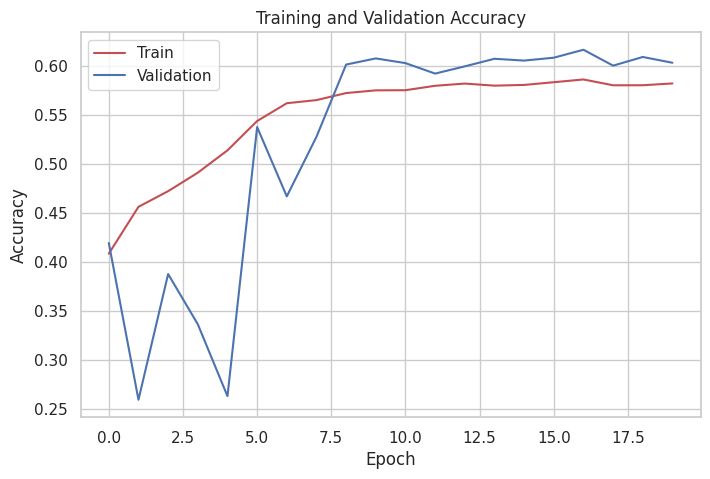

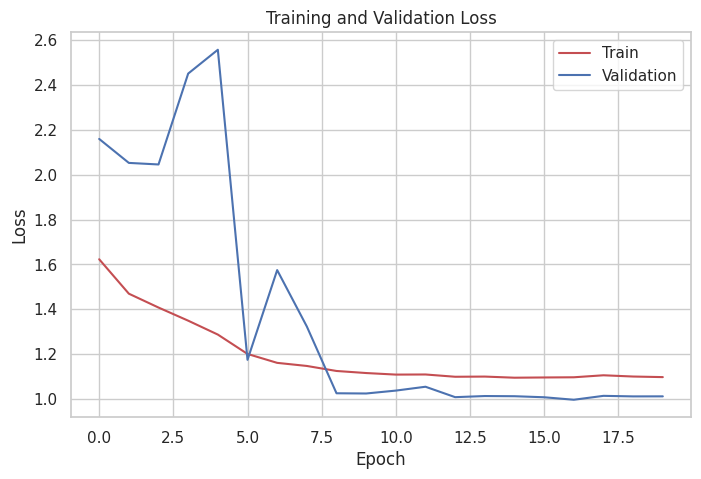

In [18]:
# Ambil nilai dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot Akurasi
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

170/170 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.5000    0.0160    0.0310       125
           1     0.6674    0.8559    0.7500       333
           2     0.5417    0.2500    0.3421       208
           3     0.3592    0.5269    0.4272       167
           4     0.8281    0.9009    0.8630       797
           5     0.8754    0.8280    0.8511       314
           6     0.2695    0.1845    0.2190       206
           7     0.3769    0.5459    0.4459       185
           8     0.3621    0.2471    0.2937       170
           9     0.3255    0.3934    0.3562       211

    accuracy                         0.6145      2716
   macro avg     0.5106    0.4749    0.4579      2716
weighted avg     0.6067    0.6145    0.5905      2716



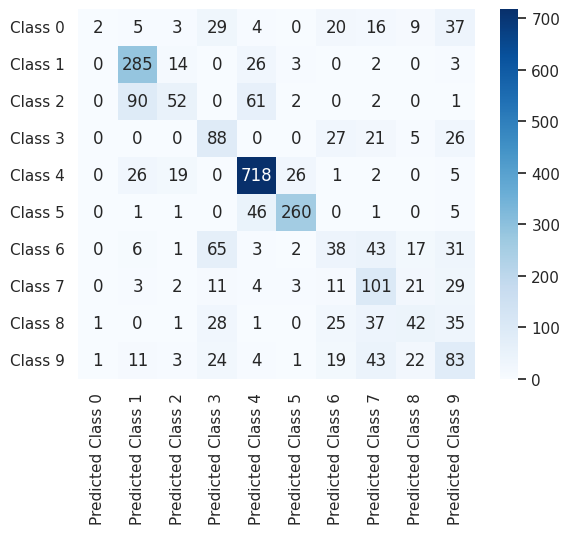

In [19]:
test_data.reset()

preds = model.predict(test_data, verbose=1)

preds_class = np.argmax(preds, axis=1)

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_data.classes, preds_class),
                  index=["Class {}".format(i) for i in range(len(test_data.class_indices))],
                  columns=["Predicted Class {}".format(i) for i in range(len(test_data.class_indices))])

# Visualisasi confusion matrix menggunakan heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(test_data.classes, preds_class, target_names=[str(i) for i in range(len(test_data.class_indices))], digits=4))

# Model Save (TFJS)

In [20]:
# Menyimpan model dalam format TFJS
output_dir = 'tfjs_model'

# Menyimpan model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [21]:
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model/')

'/kaggle/working/tfjs_model.zip'

In [22]:
files.download('tfjs_model.zip')

NameError: name 'files' is not defined